In [1]:
import numpy as np
np.warnings.filterwarnings('ignore')

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
m = ['11', '12', '01', '02',]
station = 'Haukeliseter'
analysis_time =  '12' #'00'
meps_run = ['CTRL', 'ICE-T']

nc_dir = '/home/franzihe/Documents/Data/Weathermast_MEPS_Retrieval/'  #direction to save the final file

## Minuelty observations

In [50]:
obs_double_fence_acc_mean = dict()
obs_wind_dir_10m          = dict()
obs_wind_speed_10m        = dict()
obs_dofe_temp             = dict()



obs_westerly_idx = dict()
obs_easterly_idx = dict()

obs_westerly = dict()
obs_easterly = dict()

In [92]:
for month in m:
    if month == '11':
        t = np.arange(29,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    

    for day in t:
        
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day
            
        Date = int(year+month+day)

        obs_dirnc = '/home/franzihe/Documents/Data/Weathermast/%s/CTRL_ICE-T/Met_%s_%s_%s.nc' %(station,Date,analysis_time,station)
        obs_f = xr.open_dataset(obs_dirnc)
        obs_f = obs_f.assign_coords(time = np.arange(0,1440), accum = np.arange(0,3))

        obs_double_fence_acc_mean[Date] = obs_f.double_fence_accum.mean(axis = 1, skipna = True)
        obs_wind_dir_10m[Date]   = obs_f['10m_wind_dir_mast1']
        obs_wind_speed_10m[Date] = obs_f['10m_wind_speed_mast1']
        obs_dofe_temp[Date]      = obs_f['air_temp']

#        # Calculate the moving average. That is, take
 #               # the first ten values, average them, 
  #              # then drop the first and add the eleventh, etc.
   #             # precipitation 
    #    if month != 11 and day == '01':
     #       if month == '12':
      #          previous_day = 20161130
       #     elif month == '01':
        #        previous_day = 20161231
         #   elif month == '02':
          #      previous_day = 20170131
#        else:
 #           previous_day = Date-1
  #      if Date == int(20161129):
   #         continue
    #    else:
     #       obs_dofe_acc_rolling = xr.concat([obs_double_fence_acc_mean[previous_day][-9:], 
      #                                              obs_double_fence_acc_mean[Date][:]], dim = 'time').rolling(time = 10,
       #                                                                                                  min_periods = 7,
        #                                                                                                 keep_attrs = True,
         #                                                                                                 ).mean()[9:,]
          #                                                                                                    
           #                                                                                                   
            #                                                                                                 
#            obs_wind_dir_rolling[Date] = xr.concat([obs_wind_dir_10m[previous_day][-9:],
 #                                                   obs_wind_dir_10m[Date][:]], dim = 'time').rolling(time = 10,
  #                                                                                                    min_periods = 7,
   #                                                                                                   keep_attrs = True,
    #                                                                                                  center = True,
     #                                                                                                ).mean()[9:,]
#
 #           obs_wind_speed_rolling[Date] = xr.concat([obs_wind_speed_10m[previous_day][-9:], 
  #                                                    obs_wind_speed_10m[Date][:]], dim = 'time').rolling(time = 10,
   #                                                                                                       min_periods = 7,
    #                                                                                                      keep_attrs = True,
     #                                                                                                    ).mean()[9:,]
#
 #           obs_air_temp_rolling[Date] = xr.concat([obs_dofe_temp[previous_day][-9:], 
  #                                                  obs_dofe_temp[Date][:]], dim = 'time').rolling(time = 10,
   #                                                                                                min_periods = 7,
    #                                                                                               keep_attrs = True,
     #                                                                                             ).mean()[9:,]
      #      
            

        ## calculate the precipitation difference, since the minutelty data is accumulated from the beginning
        obs_diff[Date]    = np.empty(shape = obs_double_fence_acc_mean[Date].shape)
        obs_diff[Date][:] = np.nan

        for i in range(obs_double_fence_acc_mean[Date].shape[0]-1):
                obs_diff[Date][int(i),] = obs_double_fence_acc_mean[Date][int(i)+1] - \
                                          obs_double_fence_acc_mean[Date][int(i)]

        # Find wind regimes and associated precip amount
        IDX = np.arange(obs_double_fence_acc_mean[Date].shape[0])

        ## find all obs_westerly regimes (202.5 - 22.5 deg)
        obs_westerly_idx[Date] = IDX[np.logical_or(np.logical_and(obs_wind_dir_10m[Date][:,] >= 202.5 ,
                                                                  obs_wind_dir_10m[Date][:,] <= 360.),
                                    obs_wind_dir_10m[Date][:,] < 22.5)]

        ## find all obs_easterly regimes (22.5 - 202.5 deg)
        obs_easterly_idx[Date] = IDX[np.logical_and(obs_wind_dir_10m[Date][:,] >= 22.5,
                                                    obs_wind_dir_10m[Date][:,] < 202.5)]

In [64]:
Date = 20170128

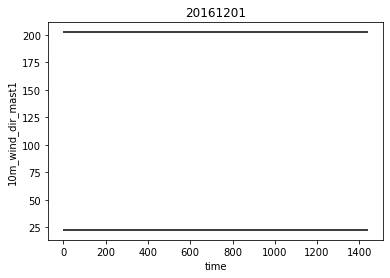

In [65]:
        fig, axs = plt.subplots(1, 1, sharex = 'all', 
                              sharey = 'all',
                            )


        obs_wind_dir_10m[Date].plot(ax = axs)
        axs.hlines(202.5, 0, 1440)
        axs.hlines(22.5, 0, 1440)
        axs.title.set_text(Date)

In [93]:
def wind_assignment_lower_10min(obs_westerly_idx, obs_easterly_idx):
        sub_idx = []   # locates the ending of the westerly burst
        for i in range(obs_westerly_idx.shape[0] -1):
            if obs_westerly_idx[i] + 1  == obs_westerly_idx[i+1]:
                continue
            else:
                sub_idx.append(i)
        sub_idx = np.asarray(sub_idx)
        
        _ww = []
        ## find westerlies which are < 10 min and assign them to obs_easterly wind regime
        if len(obs_westerly_idx) == 0 and len(sub_idx) == 0: # if there are only easterlies create empty westerly array
            obs_westerly = pd.DataFrame()
            
            if len(obs_easterly_idx) == 0:
                obs_easterly =  pd.DataFrame()
            else:
                obs_easterly = pd.DataFrame(obs_easterly_idx[:])

        elif len(obs_westerly_idx) != 0 and len(sub_idx) == 0:
            _ww = []
            obs_westerly = pd.DataFrame()
            
            if len(obs_easterly_idx) == 0:
                obs_easterly = pd.DataFrame()
            else:
                obs_easterly = pd.DataFrame(obs_easterly_idx[:])
            _west_duration = obs_westerly_idx[-1] - obs_westerly_idx[0]
            
            _ww.append(_west_duration)
            if _west_duration >= 10:  # adjusted from 28 to 10, becuase we only look at the lower 300 m with an assumed fallspeed of 1m/s and have a buffer we choose 10 min (without buffer 5min)
                obs_westerly = pd.concat([obs_westerly,
                                          pd.DataFrame(obs_westerly_idx[:])])
            elif _west_duration < 9: # adjusted from 28 to 10
                obs_easterly = pd.concat([obs_easterly,
                                          pd.DataFrame(obs_westerly_idx[:])])

        elif len(obs_westerly_idx) != 0 and len(sub_idx) !=0:
            obs_westerly = pd.DataFrame()#obs_westerly_idx)
            obs_easterly = pd.DataFrame(obs_easterly_idx)
            _ww = []
            for i in range(sub_idx.shape[0]+1):
                # calculate the durations,
                if i == 0:
                    _west_duration = obs_westerly_idx[sub_idx[i]] - \
                                     obs_westerly_idx[i]  # when at the beginning take the first sub index which locates the end of the westerly burst
                elif i == sub_idx.shape[0]:
                    _west_duration = obs_westerly_idx[-1] - \
                                     obs_westerly_idx[sub_idx[-1]+1] # when at the end take the last starting point of the westerly burst and subtract it from the last entry in the idx
                else:
                    _west_duration = obs_westerly_idx[sub_idx[i]] - \
                                     obs_westerly_idx[sub_idx[i-1]+1]  # any other time, take the ending of the westerly burst and subtract the starting of the westerly burst
                _ww.append(_west_duration)
                
                if _west_duration >= 10:
                    if i == 0:
                        obs_westerly = pd.concat([obs_westerly,
                                                        pd.DataFrame(obs_westerly_idx[i : sub_idx[0]+1])])
                    elif i == sub_idx.shape[0]:
                        obs_westerly = pd.concat([obs_westerly,
                                                        pd.DataFrame(obs_westerly_idx[sub_idx[sub_idx.shape[0]-1]+1:])])
                    else:
                        obs_westerly = pd.concat([obs_westerly,
                                                        pd.DataFrame(obs_westerly_idx[sub_idx[i-1]+1 : sub_idx[i]+1])])
                elif _west_duration < 10:
                #    print(Date, _west_duration)
                    if i == 0:
                        obs_easterly = pd.concat([obs_easterly,
                                                        pd.DataFrame(obs_westerly_idx[i : sub_idx[i]+1])])
                    elif i == sub_idx.shape[0]:
                        obs_easterly =  pd.concat([obs_easterly,
                                                        pd.DataFrame(obs_westerly_idx[sub_idx[sub_idx.shape[0]-1]+1:])])
                    else:
                        obs_easterly = pd.concat([obs_easterly,
                                                        pd.DataFrame(obs_westerly_idx[sub_idx[i-1]+1 : sub_idx[i]+1])])

                
                
 #       print(_ww)  
        if len(obs_westerly) != 0:
            obs_westerly = obs_westerly.sort_values(0, axis = 0, ascending = True, ignore_index = True)
        elif len(obs_easterly) != 0:
            obs_easterly = obs_easterly.sort_values(0, axis = 0, ascending = True, ignore_index = True)

        return(obs_westerly, obs_easterly)

In [94]:
for month in m:
    if month == '11':
        t = np.arange(29,31)
    if month == '12' or month == '01' or month == '03':
        t = np.arange(1,32)
    if month == '02':
        t = np.arange(1,29)
    if month == '11' or month == '12':
        year = '2016'
    if month == '01' or month == '02' or month == '03':
        year = '2017'
    

    for day in t:
        
        if day < 10:
            day = '0%s' %day
        else:
            day = '%s' %day
            
        Date = int(year+month+day)
        # find when westerly is < 10 min within an easterly wind
        obs_westerly[Date], obs_easterly[Date]  = wind_assignment_lower_10min(obs_westerly_idx[Date], 
                                                                              obs_easterly_idx[Date])

        if len(obs_easterly[Date]) == 0:
            print(Date, 'only westerly')
        elif len(obs_westerly[Date]) == 0:
            print(Date, 'only easterly')
        else:
            # find when easterly is < 10 min within a westerly wind
            obs_easterly[Date], obs_westerly[Date]  = wind_assignment_lower_10min(obs_easterly[Date][0].to_numpy(), 
                                                                              obs_westerly[Date][0].to_numpy(), )

20161129 only westerly
20161130 only westerly
20161201 only westerly
20161202 only westerly
20161203 only westerly
20161204 only westerly
20161208 only westerly
20161210 only westerly
20161220 only easterly
20161224 only westerly
20161225 only westerly
20161226 only westerly
20161230 only westerly
20161231 only westerly
20170103 only westerly
20170109 only easterly
20170111 only westerly
20170118 only westerly
20170119 only westerly
20170122 only westerly
20170124 only westerly
20170201 only easterly
20170206 only westerly
20170207 only westerly
20170208 only westerly
20170218 only westerly
20170219 only westerly
20170220 only westerly
20170224 only westerly
20170225 only westerly
20170227 only easterly


In [104]:
obs_diff_2deg = dict()

In [180]:
Date = 20161207

In [181]:
obs_diff_2deg[Date] = pd.DataFrame(obs_diff[Date])

In [199]:
filter = obs_dofe_temp[Date].to_dataframe()['air_temp'] <= 2.

In [206]:
obs_diff_2deg[Date].where(filter,inplace = True, other = np.nan)

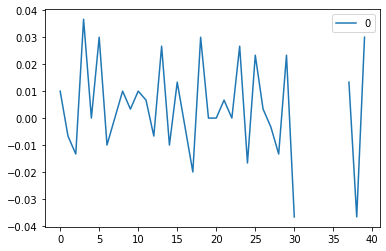

In [207]:
obs_diff_2deg[Date].plot()

ValueError: coords is not dict-like, but it has 1440 items, which does not match the 1 dimensions of the data

In [101]:
obs_diff[Date].shape

(1440,)

In [99]:
obs_f.time

<xarray.DataArray 'time' (time: 1440)>
array([   0,    1,    2, ..., 1437, 1438, 1439])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 ... 1433 1434 1435 1436 1437 1438 1439